In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [2]:
from F2_train_test_split_functions import func_test_train_split_msoa_single

### Classification of steady features to predict EV presence

In this notebook we tune and run an XGBoost model to predict the presence of EVs in each MSOA region.

In [4]:
df = pd.read_csv('../data/msoa_today_steady.csv')
print(df.shape)
df.head()

(5740, 12)


,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11,msoa11cd,ev_count,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe,E02004297,2,41,11.090909,15.378788,15387.466659
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation,E02004290,1,70,11.090909,15.378788,12941.948564
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town,E02004298,4,111,11.090909,15.378788,19825.929444
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town,E02004299,1,50,11.090909,15.378788,14636.314372
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation,E02004291,0,35,11.090909,15.378788,11049.599268


In [5]:
df['ev_present']=(df['ev_count']>0).astype(int)

In [6]:
# One hot encode our one classification variable: RUC11
df = pd.concat([df, pd.get_dummies(df['RUC11'])],axis=1)
df.drop(columns=['RUC11'],inplace=True)

In [7]:
# drop count variable, as we just want to predict present or not
df.drop(columns=['ev_count','msoa11cd'], inplace=True)
df.set_index(['MSOA11CD'],inplace=True)

In [8]:
y = df[['ev_present']]
X = df.drop(columns=['ev_present'])

In [9]:
X_train, y_train, X_test, y_test = func_test_train_split_msoa_single(X,y,0.7,45)

## Initial run

In [10]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0).fit(X_train, y_train.values.ravel())

In [11]:
clf.score(X_test, y_test)

0.6906558328496808

In [12]:
y_pred = clf.predict(X_test)

In [13]:
confusion_matrix(y_test, y_pred)

array([[  67,  325],
       [ 208, 1123]])

## Cross validation

In [14]:
# - cross validataion
xgb = XGBClassifier(use_label_encoder=False)
scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

[13:42:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:44:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:45:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [15]:
xgb.fit(X_train, y_train.values.ravel())
ypred = xgb.predict(X_test)

[13:46:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
confusion_matrix(y_test,ypred)

array([[  56,  336],
       [ 120, 1211]])

In [17]:
confusion_matrix(y_test,ypred) / len(y_test)

array([[0.03250145, 0.19500871],
       [0.06964597, 0.70284388]])

In [18]:
# pull msoas tp, tn, fp, fn and plot feature distributions
y_pred_proba = xgb.predict_proba(X_test)

In [19]:
tp_index = []
tn_index = []
fn_index = []
fp_index = []

for i in range(len(y_pred)):
    if (y_test.ev_present[i] == 1) and (ypred[i] == 1):
        tp_index.append(i)
    elif (y_test.ev_present[i] == 1) and (ypred[i] == 0):
        fn_index.append(i)
    elif (y_test.ev_present[i] == 0) and (ypred[i] == 1):
        fp_index.append(i)
    elif (y_test.ev_present[i] == 0) and (ypred[i] == 0):
        tn_index.append(i)

In [20]:
msoa_test = y_test.index

In [21]:
msoa_test_tp = msoa_test[tp_index]
msoa_test_fn = msoa_test[fn_index]
msoa_test_fp = msoa_test[fp_index]
msoa_test_tn = msoa_test[tn_index]

In [22]:
# add labelling to dataframe to then do a hue'd pairplot
df['clf_label']=np.nan

In [23]:
df.loc[msoa_test_tp,'clf_label'] = 'TP'
df.loc[msoa_test_tn,'clf_label'] = 'TN'
df.loc[msoa_test_fp,'clf_label'] = 'FP'
df.loc[msoa_test_fn,'clf_label'] = 'FN'

In [24]:
df_test = df[df['clf_label'].isin(['TP','FP','FN','TN'])]
df_test.head()

,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019,ev_present,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation,clf_label
MSOA11CD,,,,,,,,,,,,,,,,,,
E02004290,43260.0,135343.750000,21972.500000,8.0,70,11.090909,15.378788,12941.948564,1,0,0,0,0,0,0,1,0,TP
E02004300,29865.0,88300.000000,6907.200000,3.0,38,11.090909,15.378788,14354.630756,1,0,0,0,0,1,0,0,0,TP
E02004292,40150.0,166175.300000,21953.600000,8.0,23,11.090909,15.378788,15879.960753,1,0,0,0,0,0,0,1,0,TP
E02004302,31120.0,71199.000000,5116.600000,2.0,45,11.090909,15.378788,13767.257893,1,0,0,0,0,1,0,0,0,TP
E02004303,35195.0,94658.333333,13136.333333,4.5,34,11.090909,15.378788,16603.469772,1,0,0,0,0,1,0,0,0,TP


<Figure size 1440x1296 with 0 Axes>

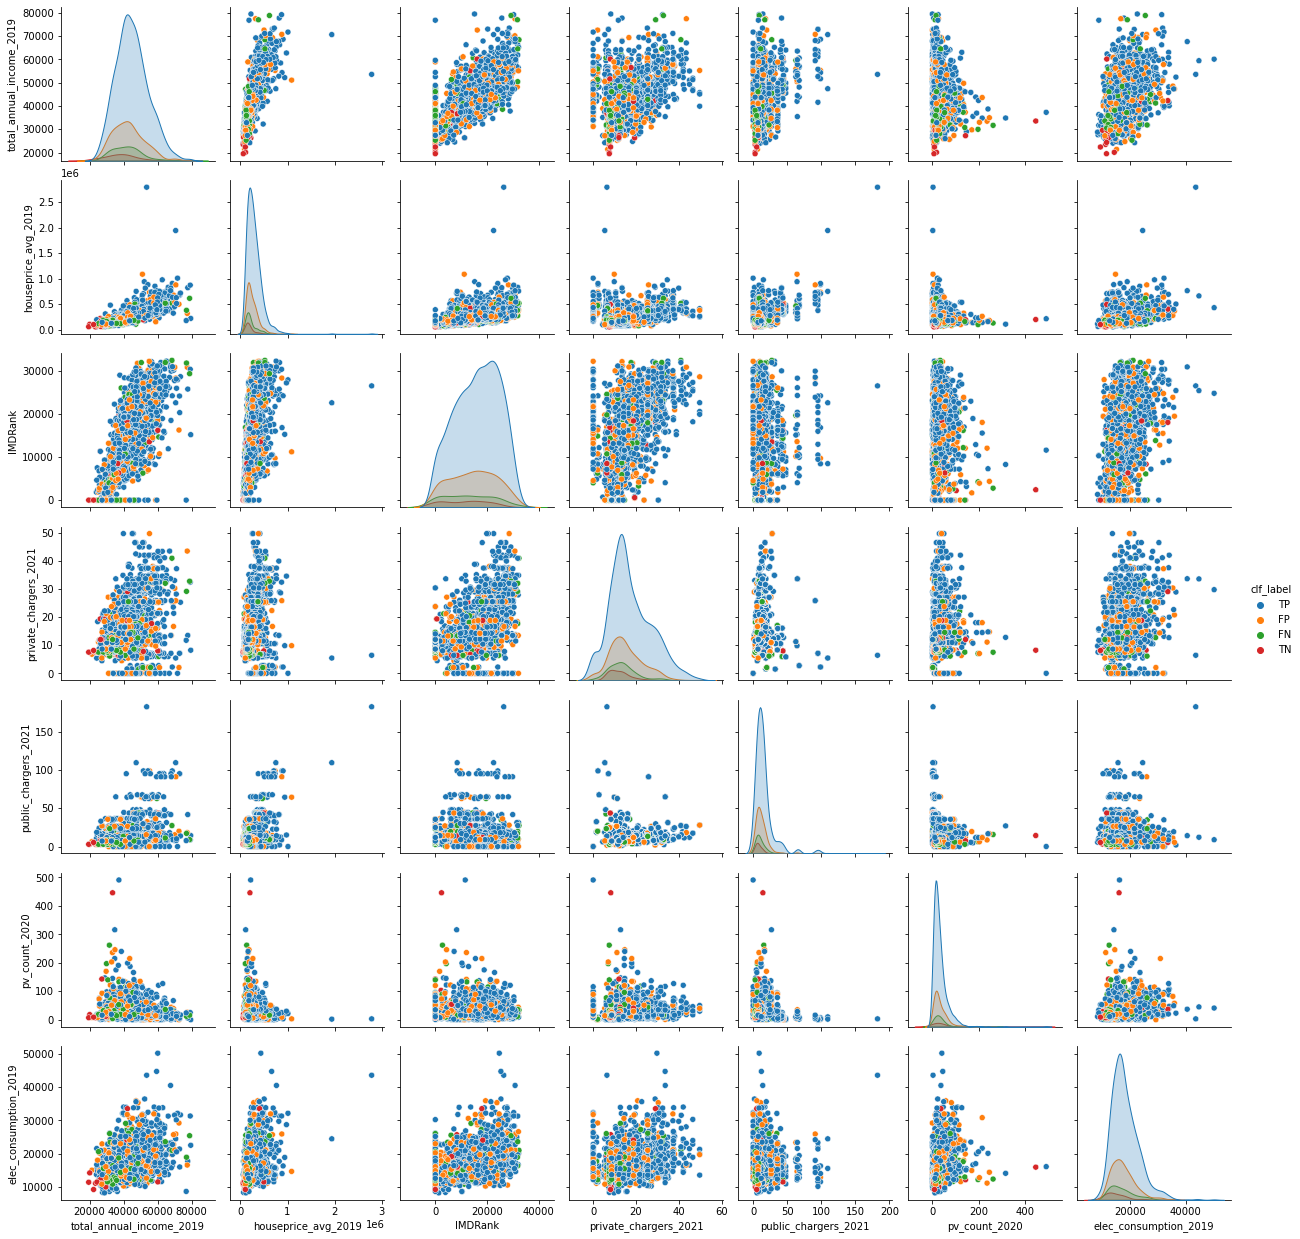

In [25]:
plt.figure(figsize=(20, 18))
sns.pairplot(df_test[['total_annual_income_2019','houseprice_avg_2019',
                    'IMDRank', 'private_chargers_2021','public_chargers_2021',
                      'pv_count_2020','elec_consumption_2019','clf_label']],hue="clf_label")

plt.show()

## Visualise results


In [27]:
msoa_geom = gpd.read_file('../data/Middle_Layer_Super_Output_Areas_(December_2011)_Boundaries.geojson')

In [28]:
msoa_geom.to_crs({'init': 'epsg:27700'}, inplace=True)

In [29]:
msoa_geom = msoa_geom[['msoa11cd','msoa11nm','geometry']]

In [30]:
df_test = msoa_geom.merge(df_test.reset_index(), left_on='msoa11cd',right_on='MSOA11CD')

<AxesSubplot:>

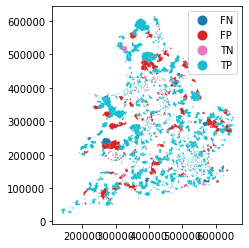

In [31]:
df_test.plot(column="clf_label",categorical=True, legend=True)

In [32]:
df_geom = msoa_geom.merge(df.reset_index(),left_on='msoa11cd',right_on='MSOA11CD',how='inner')

<AxesSubplot:>

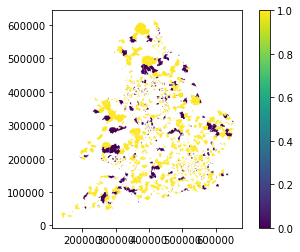

In [33]:
df_test.plot(column=['ev_present'],legend=True)

## Hyperparameter tuning

In [34]:
import xgboost as xgb

In [35]:
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [36]:
params = {'learning_rate':0.01,  
          'colsample_bytree': 0.4,
          'subsample': 0.8,
          'objective':'binary:logistic', 
          'n_estimators':500, 
          'max_depth':4,
          'gamma':1}

In [37]:
np.linspace(0.01, 0.1, 10)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [38]:
gridsearch_params = [
    (learning_rate, subsample,colsample_bytree)
    for learning_rate in np.linspace(0.01, 0.1, 5)
    for subsample in [0.8,0.9,1]
    for colsample_bytree in [0.5,0.6,0.7,0.8]
    ]

In [39]:
best_score = 0
best_params = None

#for n_estimators, max_depth in gridsearch_params:
for learning_rate, subsample, colsample_bytree in gridsearch_params:
    
    print("CV with learning_rate={}, subsample={}, colsample_bytree={}".format(
                             learning_rate,
                             subsample,
                             colsample_bytree))
    

    # Update params and run CV
    model = xgb.XGBClassifier(use_label_encoder=False,
                          learning_rate=learning_rate,  
                          colsample_bytree= colsample_bytree,
                          subsample=subsample,
                          objective='binary:logistic', 
                          n_estimators=500, 
                          max_depth=4,
                          gamma=1)
    
    #eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = ["auc","error"]
    model.fit(X_train, y_train.values.ravel(), eval_metric=eval_metric,verbose=False)
    model_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    #model.score(X_test, y_test)
    
    if model_score > best_score:
        best_score = model_score
        #best_params = (n_estimators,max_depth)
        best_params = (learning_rate, subsample,colsample_bytree)

# print("Best accuracy {} achieved for n_estimators={}, max_depth={}".format(best_score,
#                                                                            best_params[0],
#                                                                            best_params[1]))

print("Best accuracy {} achieved for learning_rate={}, subsample={}, colsample={}".format(best_score,
                                                                           best_params[0],
                                                                           best_params[1],
                                                                           best_params[2]))

CV with learning_rate=0.01, subsample=0.8, colsample_bytree=0.5
[14:11:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

[14:27:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:30:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV with learning_rate=0.0325, subsample=0.8, colsample_bytree=0.6
[14:30:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:31:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'loglos

[14:33:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV with learning_rate=0.0325, subsample=0.9, colsample_bytree=0.8
[14:33:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'loglos

CV with learning_rate=0.05500000000000001, subsample=0.8, colsample_bytree=0.6
[14:37:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'erro

[14:40:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[14:43:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV with learning_rate=0.0775, subsample=0.8, colsample_bytree=0.7
[14:43:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'loglos

[14:46:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV with learning_rate=0.0775, subsample=1, colsample_bytree=0.5
[14:47:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

[14:49:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV with learning_rate=0.1, subsample=0.8, colsample_bytree=0.7
[14:49:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'.

[14:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [40]:
best_params

(0.01, 0.9, 0.5)

### Tuned hyperparameters

learning_rate=0.01
colsample_bytree=0.9
subsample=0.5,
n_estimators=500, 
max_depth=4,


In [41]:
model = xgb.XGBClassifier(use_label_encoder=False,
                          learning_rate=0.01,  
                          colsample_bytree= 0.9,
                          subsample=0.5,
                          objective='binary:logistic', 
                          n_estimators=500, 
                          max_depth=4,
                          gamma=1) 
eval_metric = ["auc","error"]
model.fit(X_train, y_train.values.ravel(), eval_metric=eval_metric,verbose=False)
cross_val_score(model, X_train, y_train, cv=5).mean()

[14:54:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:55:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:55:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.7615140362942447

In [42]:
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

In [65]:
confusion_matrix(y_test['ev_present'],y_pred)

array([[   7,  385],
       [   5, 1326]])

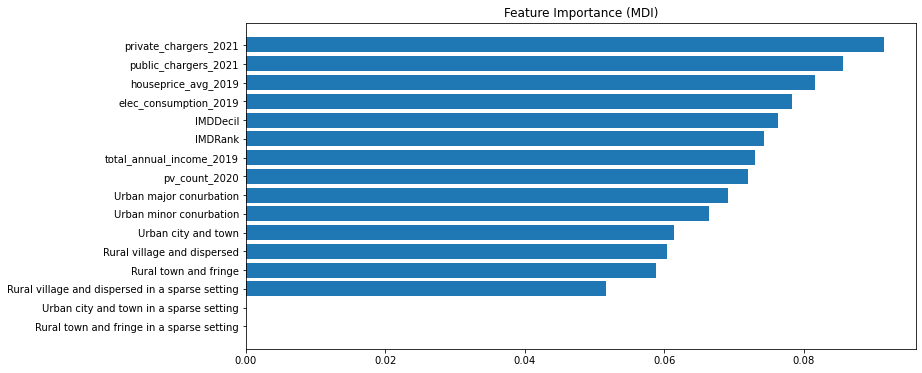

In [58]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))

plt.subplot()#1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.savefig('classification_features.png',bbox_inches="tight")
# result = permutation_importance(model, X_test, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(result.importances[sorted_idx].T,
#             vert=False, labels=np.array(X_test.columns)[sorted_idx])
# plt.title("Permutation Importance (test set)")
# fig.tight_layout()
# plt.show()

In [44]:
# visualise
#df_test = msoa_geom.merge(df_test.reset_index(), left_on='msoa11cd',right_on='MSOA11CD')
msoa_geom.head()

,msoa11cd,msoa11nm,geometry
0,E02000001,City of London 001,"POLYGON ((532155.511 182165.404, 532151.707 18..."
1,E02000002,Barking and Dagenham 001,"POLYGON ((548879.561 191097.582, 548876.630 19..."
2,E02000003,Barking and Dagenham 002,"POLYGON ((548960.412 189072.420, 548963.469 18..."
3,E02000004,Barking and Dagenham 003,"POLYGON ((551551.895 187364.909, 551551.617 18..."
4,E02000005,Barking and Dagenham 004,"POLYGON ((549238.922 187628.172, 549237.989 18..."


In [45]:
y_pred_proba

array([[0.12155652, 0.8784435 ],
       [0.16405463, 0.83594537],
       [0.07987809, 0.9201219 ],
       ...,
       [0.19453406, 0.80546594],
       [0.0638271 , 0.9361729 ],
       [0.0409044 , 0.9590956 ]], dtype=float32)

In [46]:
tp_index = []
tn_index = []
fn_index = []
fp_index = []

for i in range(len(y_pred)):
    if (y_test.ev_present[i] == 1) and (y_pred[i] == 1):
        tp_index.append(i)
    elif (y_test.ev_present[i] == 1) and (y_pred[i] == 0):
        fn_index.append(i)
    elif (y_test.ev_present[i] == 0) and (y_pred[i] == 1):
        fp_index.append(i)
    elif (y_test.ev_present[i] == 0) and (y_pred[i] == 0):
        tn_index.append(i)

In [47]:
msoa_test = y_test.index
msoa_test_tp = msoa_test[tp_index]
msoa_test_fn = msoa_test[fn_index]
msoa_test_fp = msoa_test[fp_index]
msoa_test_tn = msoa_test[tn_index]

In [48]:
y_test.loc[msoa_test_tp,'clf_label'] = 'TP'
y_test.loc[msoa_test_tn,'clf_label'] = 'TN'
y_test.loc[msoa_test_fp,'clf_label'] = 'FP'
y_test.loc[msoa_test_fn,'clf_label'] = 'FN'
y_test.head()

,ev_present,clf_label
MSOA11CD,,
E02004402,1,TP
E02006232,1,TP
E02002888,1,TP
E02000455,1,TP
E02002313,1,TP


In [49]:
y_test_geom = msoa_geom.merge(y_test.reset_index(), left_on='msoa11cd',right_on='MSOA11CD')
print(y_test.shape)
print(y_test_geom.shape)

(1723, 2)
(1723, 6)


In [50]:
y_train_geom = msoa_geom.merge(y_train.reset_index(), left_on='msoa11cd',right_on='MSOA11CD')
print(y_train.shape)
print(y_train_geom.shape)

(4017, 1)
(4017, 5)


In [51]:
X_test.loc[msoa_test_tp,'clf_label'] = 'TP'
X_test.loc[msoa_test_tn,'clf_label'] = 'TN'
X_test.loc[msoa_test_fp,'clf_label'] = 'FP'
X_test.loc[msoa_test_fn,'clf_label'] = 'FN'
X_test.head()

,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,pv_count_2020,public_chargers_2021,private_chargers_2021,elec_consumption_2019,Rural town and fringe,Rural town and fringe in a sparse setting,Rural village and dispersed,Rural village and dispersed in a sparse setting,Urban city and town,Urban city and town in a sparse setting,Urban major conurbation,Urban minor conurbation,clf_label
MSOA11CD,,,,,,,,,,,,,,,,,
E02004402,28850.0,175200.000000,9291.40,3.0,11,6.000000,22.181818,15586.240337,0,0,0,0,1,0,0,0,TP
E02006232,45990.0,291750.000000,20945.00,7.0,88,10.363636,20.000000,18478.186465,0,0,1,0,0,0,0,0,TP
E02002888,25760.0,116250.000000,2080.00,1.0,73,23.789474,8.657895,11040.127425,0,0,0,0,0,0,0,1,TP
E02000455,53870.0,339578.125000,16223.50,5.5,4,3.900000,20.466667,13793.436194,0,0,0,0,0,0,1,0,TP
E02002313,32610.0,139737.435611,3290.75,1.0,8,6.135593,14.847458,11455.448642,0,0,0,0,0,0,1,0,TP


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda/envs/Python3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1440x1296 with 0 Axes>

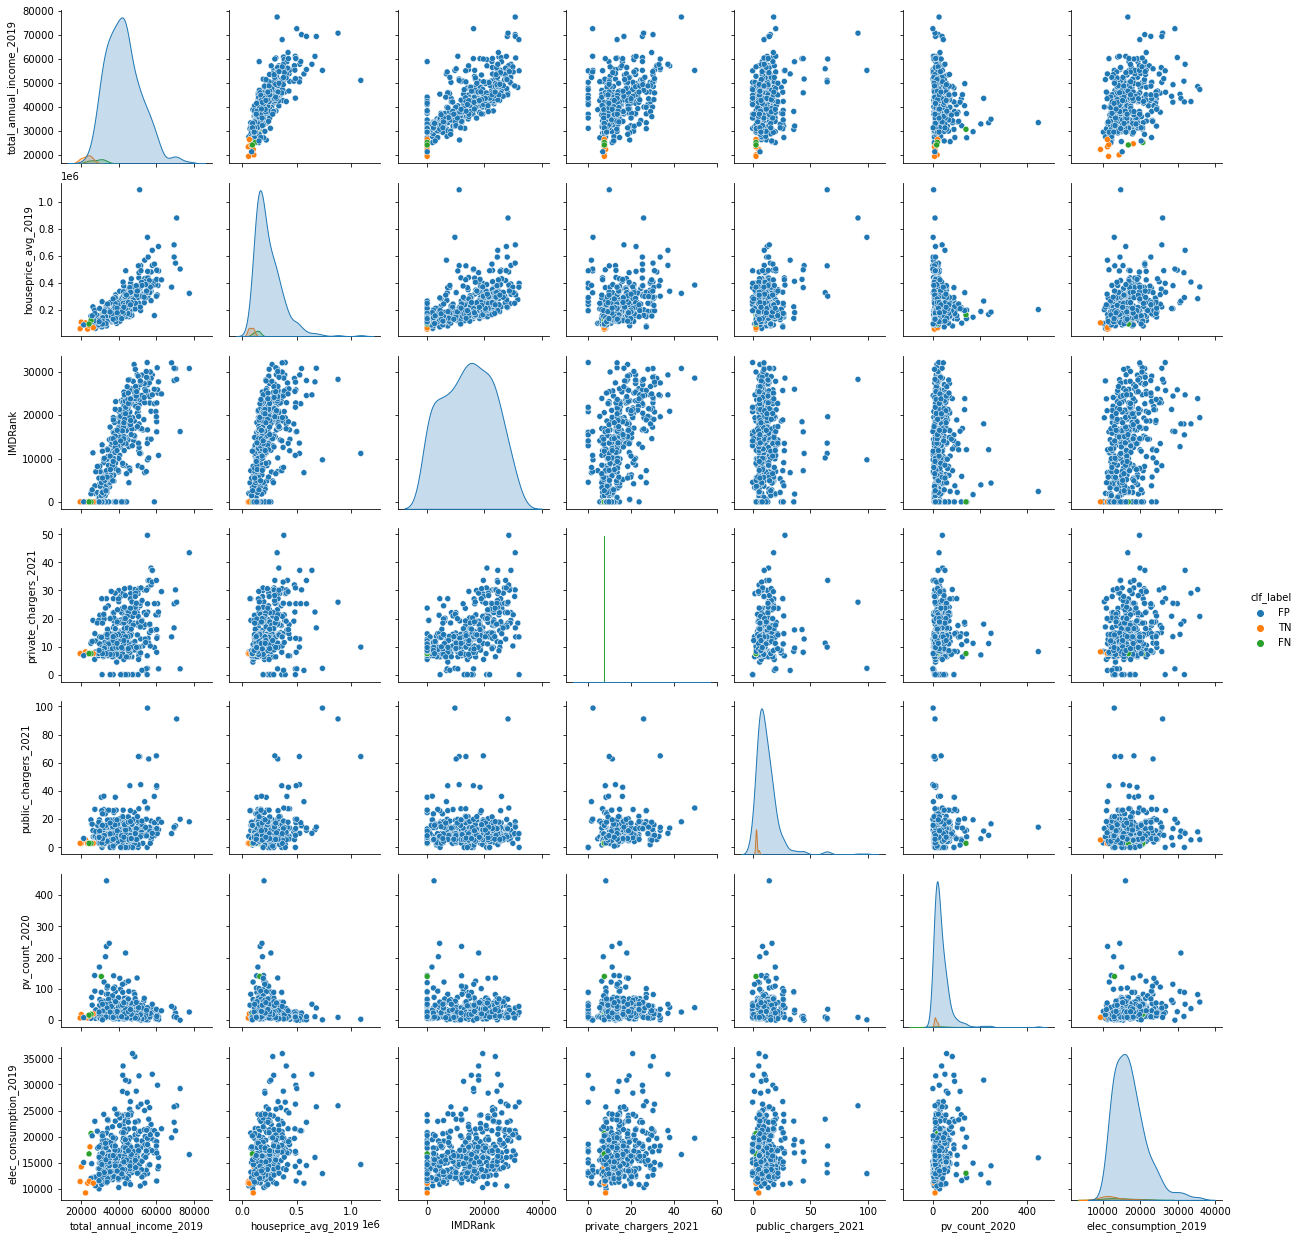

In [52]:
plt.figure(figsize=(20, 18))
X_fn_fp_tn = X_test[X_test['clf_label'].isin(['FN','FP','TN'])]
sns.pairplot(X_fn_fp_tn[['total_annual_income_2019','houseprice_avg_2019',
                    'IMDRank', 'private_chargers_2021','public_chargers_2021',
                      'pv_count_2020','elec_consumption_2019','clf_label']],hue="clf_label")

plt.show()

In [53]:
# loop through false positives to find an interesting example
def func_get_msoa_neighbours(msoa, df_geom):
    """Function to pull neighbours of the MSOA region from the full dataset df_geom."""
    msoa_row = df_geom[df_geom['msoa11cd'] == msoa]

    for index, row in msoa_row.iterrows():   

        # get 'not disjoint' countries
        neighbours = msoa_geom[~msoa_geom.geometry.disjoint(row.geometry)].msoa11cd.tolist()

        # remove own name of the country from the list
        neighbours = [ candidate for candidate in neighbours if candidate != msoa ]

    return neighbours

<AxesSubplot:>

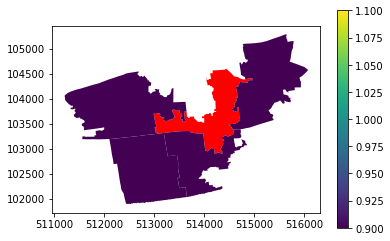

In [54]:
msoa_fp_sample = np.random.choice(msoa_test_fp)
neighbours = func_get_msoa_neighbours(msoa_fp_sample, msoa_geom)

# plot msoa region and its neighbours
fig, ax = plt.subplots()
df_geom[df_geom['msoa11cd']==msoa_fp_sample].plot(ax=ax, color='r')
df_geom[df_geom['msoa11cd'].isin(neighbours)].plot(ax=ax, column='ev_present',legend=True)

In [55]:
msoa_fp_sample

'E02006628'

NameError: name 'df_test_geom' is not defined

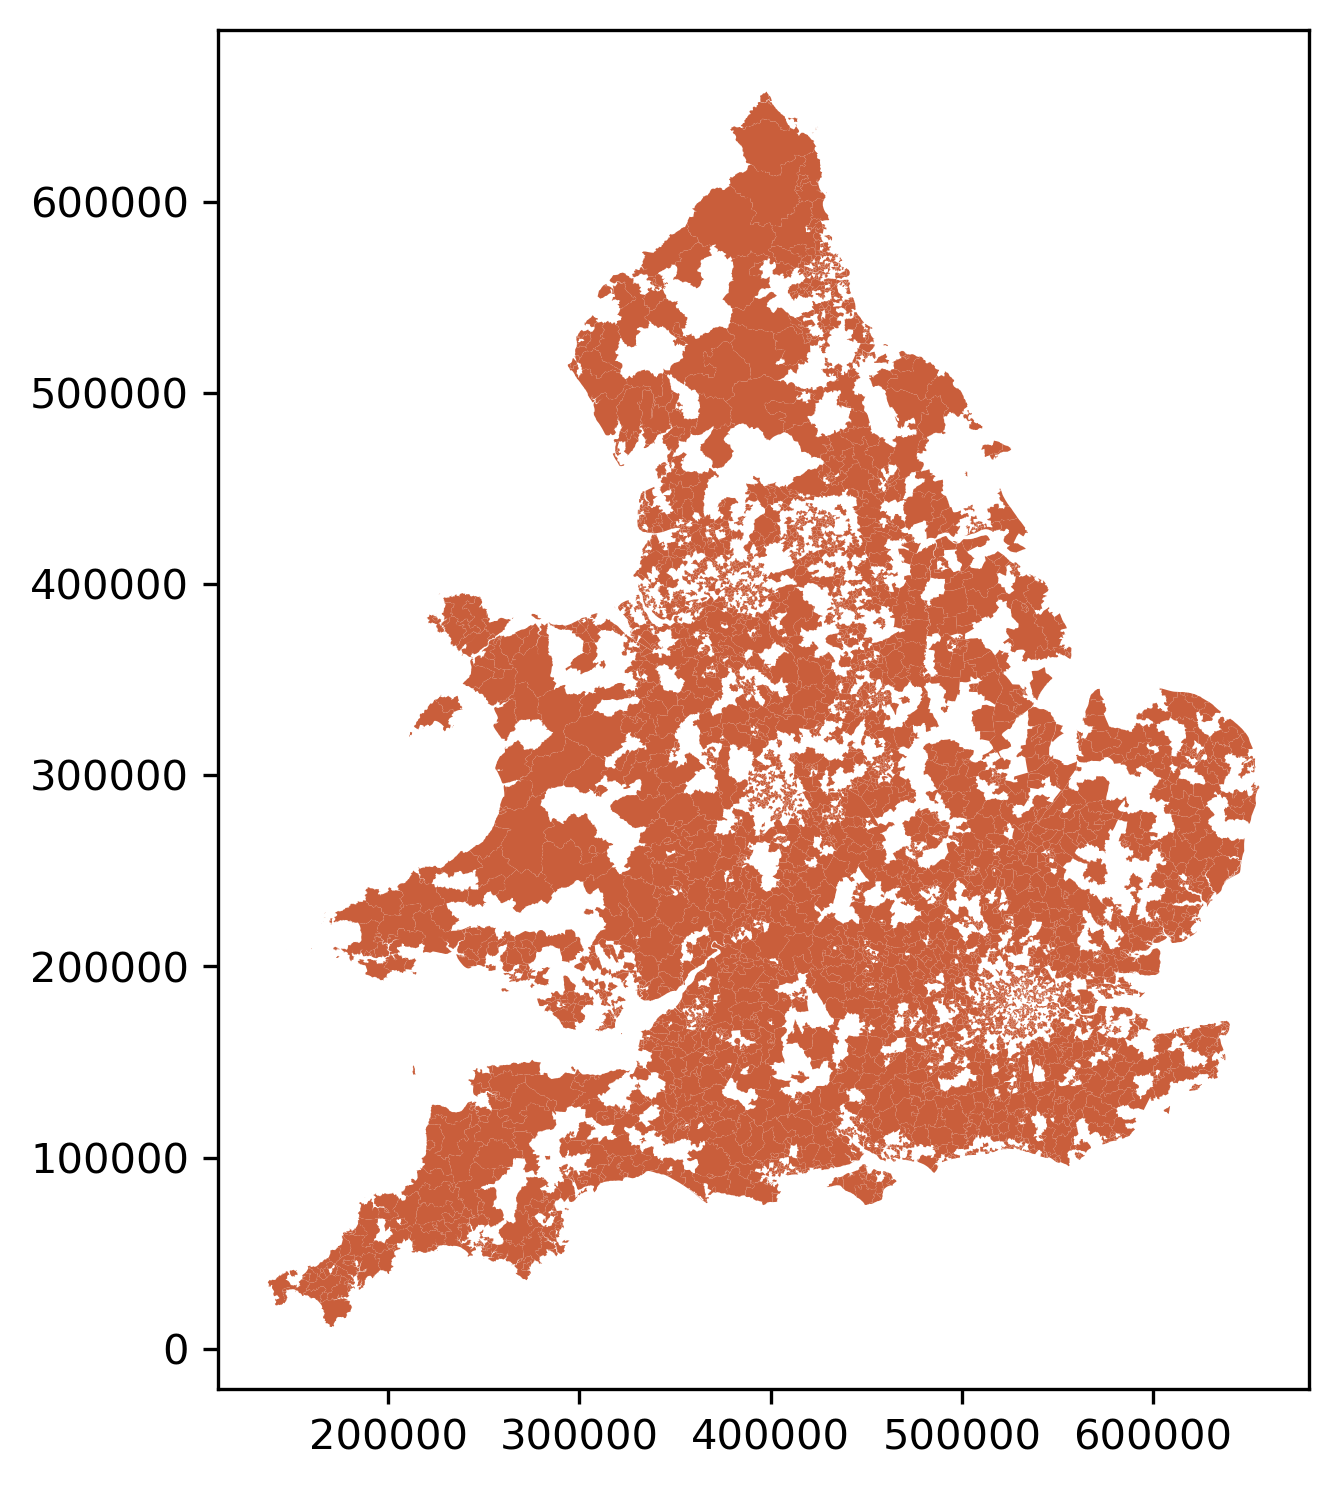

In [56]:
# Figure showing where there are EVs in the MOT data and the FP regions

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
#msoa_sample_count.plot(column='ev_count_2021',ax=ax,legend=True)#,color='#0f2b43')
df_geom[df_geom['ev_present']==1].plot(ax=ax, color='#c95e3b')
df_test_geom[df_test_geom['clf_label']=='FP'].plot(ax=ax, color='#0f2b43')
plt.axis('off')
#plt.savefig('msoa_fp_tp.png', transparent=True)

In [ ]:
df_test_geom = msoa_geom.merge(y_test.reset_index(), left_on='msoa11cd', right_on='MSOA11CD', how='inner')
# df_train_geom = msoa_geom.merge(y_train.reset_index(), left_on='msoa11cd', right_on='MSOA11CD', how='inner')